<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

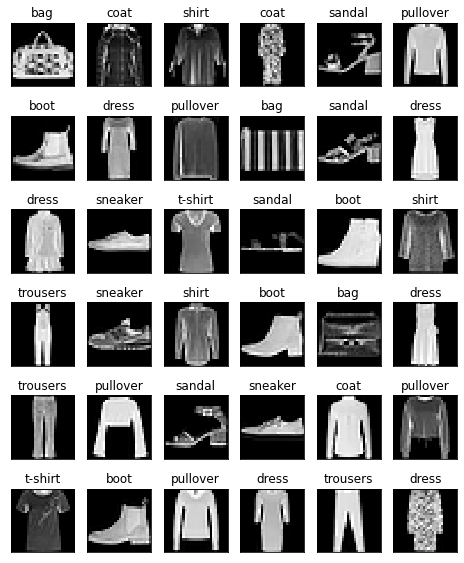

In [2]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
st_idx = R.randint(0, train_images.shape[0]-N*N-1)
for i in range(N*N):
    plt.subplot(N,N,i+1)
    plt.imshow(train_images[st_idx+i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx+i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Q1a: Autoassociator

Note on Homework 7 that for the autoencoder (Q1a), you should use linear activation functions on the outputs (as a regression-type problem). For this, I've asked you to have it develop PCA-like representations, which means also using linear activation functions on the hidden layer. With a regression-type problem, mean_squared_error is an appropriate loss function

(I just realized that the autoencoder code I shared in Homework 1 used a nonlinear hidden layer, which is fine but not PCA-like, had sigmoidal output activations, which is ok since the pixel values are normalized to fall between 0 and 1, but had an inappropriate objective function - I think I copied that code from someplace at one time and hadn't bothered to check it closely since it was just a quick demo to make sure Keras/Tensorflow was working.)

In [3]:
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
def plot_model_accuracy(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [4]:
# Reshape the training images to be a flattened 2D representation
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))

# Expand the training labels to be 2D
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

# Shuffle all vector (THE SAME ORDER)
shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

# Take half of the above for the training data for Q1a
train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

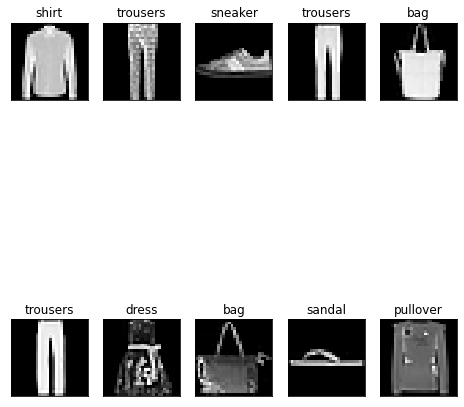

In [5]:
train_imagesREMAKE_shuffled = np.reshape(train_shuffled, (train_shuffled.shape[0],28,28))

# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_imagesREMAKE_shuffled[i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels_shuffled[i][0]])
    plt.xticks([])
    plt.yticks([])
plt.show()

# Automated Attempts

In [6]:
def generate_aa(encoding_dim, act1, act2, loss_func, train_half, train_half_labels, my_epochs=20, my_batch=256):
    # this is our input placeholder
    input_img = layers.Input(shape=(new_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation=act1)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(new_dim, activation=act2)(encoded)

    # this model maps an input to its reconstruction
    autoencoder = models.Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = models.Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = layers.Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = models.Model(encoded_input, decoder_layer(encoded_input))

    # compile model
    autoencoder.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

    print(train_half.shape)
    print(train_labels_half.shape)

    # My code here
    x_train = train_half[0:int(train_half.shape[0]*0.8), :]
    x_test = train_half[int(train_labels_half.shape[0]*0.8):, :]

    x_train = x_train / np.amax(train_half)
    x_test = x_test / np.amax(train_half)

    print(x_train.shape)
    print(x_test.shape)

    history = autoencoder.fit(x_train, x_train,
                    epochs=my_epochs,
                    batch_size=my_batch,
                    verbose = False,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    plot_model_loss(history)
    plot_model_accuracy(history)
    
    return autoencoder, history

(30000, 784)
(30000, 1)
(24000, 784)
(6000, 784)


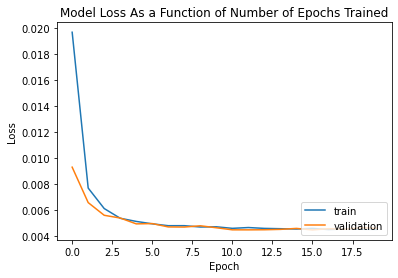

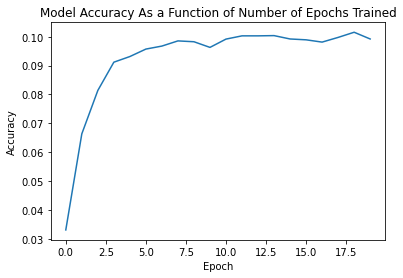

In [25]:
encoding_dim = 200
aa200, aahistory = generate_aa(encoding_dim, 'linear', 'linear', 'mean_squared_error', train_half, train_labels_half, my_batch=30)

## Q1b
> Use the remaining half of the original set as inputs to train a densely connected multilayer NN that learns, via backpropagation to classify the images.
1. Pick the proper activiation functions n the hidden units
2. Pick the proper activation function on the output units for a classificaiotn network
3. Make sure you also pick a proper loss function for a classification network

--> Multiclass classification: Relu, softmax, categorical_cross_entropy

In [9]:
def create_network(node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='categorical_crossentropy'):
    network = models.Sequential()
        
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list)-1:
            my_func = 'softmax'
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [10]:
def run_pipeline(train_array, train_labels, test_dim, test_pats=None, test_labels=None, num_epochs=30, my_batch=30):
    best_acc = -1
    best_val_acc = -1
    
    input_dim = train_array.shape[1]
    
    for _ in range(5):
        network = create_network(test_dim, input_dim)
        
        history = network.fit(train_array, 
                              train_labels, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
        print('Done training!')
        
        # Determine if this model was better than the previous ones
        new_acc = history.history['acc'][-1]
        new_val_acc = history.history['val_acc'][-1]
        if new_acc > best_acc and new_val_acc > best_val_acc:
            best_acc = new_acc
            best_val_acc = new_val_acc
            best_history = history
            best_network = network
        # Show the accuracy plot each time
        # plot_model_acc(history)

    # Show the accuracy of the best plot
    plot_model_acc(best_history)
    
    '''
    out = best_network.predict(
       test_pats, 
       batch_size = my_batch, 
       verbose = 0,  
       workers = 1, 
       use_multiprocessing = False)
    
    results = best_network.evaluate(test_pats, 
                           test_labels_onehot_2D, 
                           verbose=False)

    test_loss = results[0]
    test_acc = results[1]

    print('test_loss (MSE)     : {}'.format(test_loss))
    print('test_acc (%Correct) : {}'.format(test_acc))
    '''
    
    return best_network, best_history #, out, results

In [11]:
train_half2 = train_shuffled[train_shuffled.shape[0]//2:]
train_labels_half2 = train_labels_shuffled[train_shuffled.shape[0]//2:]

print(train_half2.shape)
print(train_labels_half2.shape)

(30000, 784)
(30000, 1)


# From the man himself:
> Instead of "fixing these weights" just use the weights and biases to calculate the activations, which will then be used as inputs to a trained network

In [40]:
aanetwork = aa200
aanetwork.summary()

aaW = aanetwork.layers[1].get_weights()[0]
aab = aanetwork.layers[1].get_weights()[1]

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               157584    
Total params: 314,584
Trainable params: 314,584
Non-trainable params: 0
_________________________________________________________________


In [43]:
backprop_network = create_network(node_list=[new_dim,encoding_dim,30,20,10])
backprop_network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_15 (Dense)             (None, 30)                6030      
_________________________________________________________________
dense_16 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                210       
Total params: 163,860
Trainable params: 163,860
Non-trainable params: 0
_________________________________________________________________


In [38]:
def apply_weights(aaW, aab, inputs):
    inputs = np.matmul(inputs, aaW) + aab
    #"Relu" implementation for activations
    x = np.maximum(inputs, 0)
    return x

In [46]:
# y = mx + b
# fixed_inputs = W * original_inputs + b

fixed_input = apply_weights(aaW, aab, train_half)

print(fixed_input.shape)
backprop_network.layers[1].set_weights(fixed_input)

(30000, 200)


ValueError: You called `set_weights(weights)` on layer "dense_15" with a  weight list of length 30000, but the layer was expecting 2 weights. Provided weights: [[ 0.        50.963516   0.        ... 11.695036  ...

In [ ]:
my_epochs=20
my_batch=256

history2 = network.fit(train_half2, 
                              train_labels_half2, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)

In [ ]:
network = models.Sequential()

network.add(layers.Dense(test_dim, 
                 activation='relu', 
                 input_shape=(input_dim,)))
network.add(layers.Dense(input_dim, 
                 activation='softmax', 
                 input_shape=(test_dim,)))

# configure optimizer
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
network.compile(optimizer='adam', 
                loss='mean_squared_error', 
                metrics=['accuracy', 'mse'])

## Q2: Use a CNN to Classify the Fashion MNIST

In [ ]:
network = models.Sequential()

# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
input_sz = 28
# second convolution layer parameters
num_fm_2 = 16

# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# padding='valid'
# ^This is the default. It stays inside the previous layer
# 'same' --> Goes outside previous layer --> This is what we "may want to use"

# strides=(1,1)
# ^(default) convolution full covers previous layer
# Usually use full stride
# strides=(2,2) has gaps

# second convolution layer
network.add(layers.Conv2D(num_fm_2, (conv_dim, conv_dim)))

for layer in network.layers:
    print('layer name: {} | input shape: {} | output shape: {}'.
          format(layer.name, layer.input.shape, layer.output.shape))



In [ ]:
train_imagesRE = train_images.reshape(train_images.shape[0], input_sz, input_sz, 1)